# CS85 AI Guided Financial Trading

### Base on: GRYP + MACD  Trading Events & 11 Ta Indicators


***Prediction:***

Min_10: Minimum Price after 10 time steps

Max_10: Maximum Price after 10 time steps

BHS Labels (eg:ws10_pt10_sl8): 

buy/sell: enter market. Will hit Profit Taken= 10 pip First in the next 10 windows, Stop Loss =8 pip 

hold: Do not enter market.   Will hit Stop Loss =8 pip First in the next 10 windows, Profit Taken =10 pip 

<div style="text-align:right"> Wang Keyu </div>
<div style="text-align:right"> Ziying Cen </div>
<div style="text-align:right"> Date: Nov 25th, 2022 </div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation,Flatten
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report
import keras.metrics
from keras.models import load_model


In [2]:
data = pd.read_csv('C:\\Users\\HFY\\Desktop\\capstone\\w11\\combine\\AUD_CAD_f.csv')

# Preprocess
- DropNA
- Embedding
- MinMax Scale
- Convert BHS label into 0,1,2

In [3]:
# GRYP event embedding
GRYP_IDX = {}
for idx, value in enumerate( list(data.event.unique())):
    GRYP_IDX[value] = idx
data['event'].replace(GRYP_IDX, inplace= True)

# string to index 
REPLACE_INDEX = {'buy':1, 'hold':0, 'sell':2}
data.replace(REPLACE_INDEX, inplace= True)

NEGATIVE_INDEX = {-1 : 2}
data.replace(NEGATIVE_INDEX, inplace= True)

# check label
data.ws10_pt10_sl8.value_counts()


1    170648
0    140514
2    129706
Name: ws10_pt10_sl8, dtype: int64

In [4]:
# remove all nan
print(f'before: {data.shape}')
data.dropna(subset=['min_40', 'ratio top'],inplace=True)
data = data.reset_index(drop=True)
# train val test split 
Xtrain = data[(data['datetime']>='2018-06-25T09:00:00.000000000Z') & ((data['datetime']<='2021-09-13T00:45:00.000000000Z'))]
Xtrain.reset_index(drop=True, inplace=True)
Xvalid = data[(data['datetime']>='2021-09-13T01:00:00.000000000Z') & ((data['datetime']<='2022-02-04T07:45:00.000000000Z'))]
Xvalid.reset_index(drop=True, inplace=True)
Xtest = data[(data['datetime']>='2022-02-04T08:00:00.000000000Z') & ((data['datetime']<='2022-06-30T13:30:00.000000000Z'))]
Xtest.reset_index(drop=True, inplace=True)

print(f'after remove null values: {data.shape} \ntrain size: {Xtrain.shape}\nvalidtion size: {Xvalid.shape}\ntest size: {Xtest.shape}')


before: (440868, 183)
after remove null values: (440628, 183) 
train size: (80000, 183)
validtion size: (10000, 183)
test size: (10000, 183)


# Functions 
for evaluation purpose and generate sequnces of data

In [5]:
# define window size for label and the min max price
WINDOW_SIZE = 10

# Regression evaluation metric
def evaluate_regression_prediction(y_pred, y_true, model_name, printFlag=True):
    errors = np.array(y_pred) - np.array(y_true)
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.abs(100*errors/y_true).mean()
    if printFlag:
        print(model_name + ':')
        print('Mean Absolute Error: {:.8f}'.format(mae))
        print('Mean Absolute Percentage Error: {:.8f}'.format(mape))
        print('Mean Square Error: {:.8f}'.format(mse))
        print('Root Mean Square Error: {:.8f}'.format(rmse))
        print('')
    return mae, mape, mse, rmse

# visualize model result
def visualize_result(model, train_x_dict, train_y_dict,price_scaler_min, price_scaler_max,train_minprice,train_maxprice):
    y_pred = model.predict(train_x_dict)

    print('-' * 100)
    print('MinMax Price Prediction Result: ')

    # Inverse prediction to orginal scale
    min_output,max_output = [],[]
    for i in range(len(y_pred[0])):
        #print(price_scaler_max[i] - price_scaler_min[i], y_pred[0][i] , price_scaler_min[i] )
        max_output.append( (y_pred[0][i] * (price_scaler_max[i] - price_scaler_min[i])) + price_scaler_min[i] )
        min_output.append( (y_pred[1][i] * (price_scaler_max[i] - price_scaler_min[i])) + price_scaler_min[i] )

    _,_,_,_ =evaluate_regression_prediction(max_output,train_maxprice,'Model')
    _,_,_,_ =evaluate_regression_prediction(min_output,train_minprice,'Model')

    # visulize the Max Price Prediction & Ground True
    plt.figure(2)
    plt.figure(figsize=(15,6))
    plt.plot(max_output, label='Max Predict')
    #plt.plot(min_output, label='Min Predict')
    #plt.plot(train_minprice, label='Actual Min Price') 
    plt.plot(train_maxprice, label='Actual Max Price') 
    plt.title('Predict Max & Actual Max')
    plt.legend(loc = 'upper right')

    # visulize the Min Price Prediction & Ground True
    plt.figure(2)
    plt.figure(figsize=(15,6))
    plt.plot(min_output, label='Min Predict')
    plt.plot(train_minprice, label='Actual Min Price') 
    plt.title('Predict Min & Actual Min')
    plt.legend(loc = 'upper right')

    # Inverse buy hold sell prediction label
    if len(y_pred) >2:
        ground_true = train_y_dict['bhs']
        prediction_labelbhs = y_pred[2].argmax(axis=-1).tolist()
        print(f'Accuracy for predicting buy hold sell label: {accuracy_score(prediction_labelbhs,ground_true):.4f}')
        print(classification_report(prediction_labelbhs,ground_true))
        print('-' * 100)

def visualize_history(history):
    # visual_loss = ['maxp_loss', 'minp_loss', 'bhs_loss','val_maxp_loss', 'val_minp_loss', 'val_bhs_loss']
    visual_loss = ['maxp_loss', 'minp_loss','val_maxp_loss', 'val_minp_loss']
    visual_acc = ['Train Accuracy', 'Validation Accuracy']
    plt.figure(2)
    plt.figure(figsize=(15,6))
    for i in visual_loss:
        history.history[i]
        plt.plot(history.epoch,history.history[i], label =i )
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc = 'upper right')

    # plt.figure(2)
    # history.history[i]
    # plt.bar(x = visual_acc, height = [history.history['bhs_sparse_categorical_accuracy'][-1],history.history['val_bhs_sparse_categorical_accuracy'][-1]] )
    # plt.xlabel('Accuracy')
    # plt.ylabel('Train & Validation')
    # plt.title('Label BuyHoldSell Prediction Accuracy')
    # plt.show()

def generate_sequence(data, window_size):
    train_dt_ori, train_dt_scaled, target_minprice, target_maxprice, target_minp_scaled,\
    target_maxp_scaled, price_scaler_max, price_scaler_min = [], [], [], [], [], [], [], []
    train_dt_GRYP,train_dt_distance,ta_indicators,target_bhs,macd_1,macd_2 = [],[],[],[],[],[]

    scaler = MinMaxScaler()
    scaler_a = MinMaxScaler()
    scaler_b = MinMaxScaler()

    for index, row in data.iterrows(): 
        if index <= len(data) - window_size:
            # OHLC numerical original data
            train_dt_ori.append(data.loc[index:window_size-1+index, ['open', 'high', 'low', 'close']].values)
            # GRYP Categorical
            train_dt_GRYP.append(data.loc[index:window_size-1+index, ['event']].values)
            macd_1.append(data.loc[index:window_size-1+index, ['dir_change']].values)
            macd_2.append(data.loc[index:window_size-1+index, ['two_peaks']].values)
            # numerical feature min max scale
            train_dt_distance.append(scaler_a.fit_transform(data.loc[index:window_size-1+index, ['absolute top','absolute mid','absolute bottom',
                                                                    'ratio top','ratio mid','ratio bottom']].values))
            # TA indicators numerical min max scale
            
            ta_indicators.append(scaler_b.fit_transform(data.loc[index:window_size-1+index, [
                                        'wr15', 'wr25','wr35','atr15','rsi15','rsi25','rsi35',
                                        'atr25','atr35','STOCHk_14_3_3','STOCHd_14_3_3' ]].values))

            # MinMax scale for the given windows size
            train_dt_scaled.append(scaler.fit_transform(data.loc[index:window_size-1+index, ['open', 'high', 'low', 'close']].values))
            # Choose min_ws labels for predictions
            tmp_minprice = data.loc[window_size-1+index, f'min_{window_size}'].tolist()
            target_minprice.append(tmp_minprice)
            # Choose min_ws labels for predictions
            tmp_maxprice = data.loc[window_size-1+index, f'max_{window_size}'].tolist()
            target_maxprice.append(tmp_maxprice)
            # Choose bhs label for prediction
            target_bhs.append(data.loc[window_size-1+index, [f'ws{window_size}_pt10_sl8']].values)
            # given ws max and mim of the sequences
            max_v = max(data.loc[index:window_size-1+index, ['open', 'high', 'low', 'close']].max())
            min_v = min(data.loc[index:window_size-1+index, ['open', 'high', 'low', 'close']].min())
            
            target_minp_scaled.append((tmp_minprice-min_v)/(max_v-min_v))
            target_maxp_scaled.append((tmp_maxprice-min_v)/(max_v-min_v))
            # save the minimum and maximum for inverse transform to orginal scale
            price_scaler_max.append(max_v)
            price_scaler_min.append(min_v)

    # np.array convert correct data types
    train_arr_ohlc_scaled = np.array(train_dt_scaled).astype('float32')
    train_arr_GRYP = np.array(train_dt_GRYP).astype('int64')
    macd_1, macd_2 = np.array(macd_1).astype('int64'),np.array(macd_2).astype('int64')
    train_arr_distance = np.array(train_dt_distance).astype('float32')
    ta_indicators =  np.array(ta_indicators).astype('float32')
    target_minpArr_scaled = np.array(target_minp_scaled).astype('float32')
    target_maxpArr_scaled = np.array(target_maxp_scaled).astype('float32') 
    target_arr_bhs = np.array(target_bhs).astype('int64')

    # TrainSet Features
    train_x_dict = {
        'OHLC':train_arr_ohlc_scaled,'GRYP': train_arr_GRYP,'DISTANCE': train_arr_distance, "TAINDICATORS" : ta_indicators,
        "MACD1":macd_1, 'MACD2':macd_2
    }
    # TrainSet Ylabel
    train_y_dict = {'minp': target_minpArr_scaled, 'maxp': target_maxpArr_scaled, 'bhs':target_arr_bhs}
    
    return train_x_dict,train_y_dict, price_scaler_max,price_scaler_min,target_minprice, target_maxprice



# Train Valid Test Split

In [6]:
# Train Set
train_x_dict,train_y_dict,price_scaler_max,price_scaler_min,train_minprice, train_maxprice = generate_sequence(Xtrain,WINDOW_SIZE)
# Valid Set
valid_x_dict,valid_y_dict,val_price_scaler_max,val_price_scaler_min,valid_minprice, valid_maxprice = generate_sequence(Xvalid,WINDOW_SIZE)
# Test Set
test_x_dict,test_y_dict,test_price_scaler_max,test_price_scaler_min,test_minprice, test_maxprice = generate_sequence(Xtest,WINDOW_SIZE)

# Model Construction
- RNN for classification
- LSTM
- BiLSTM
- Transformer

In [22]:
# LSTM,BILSTM,Transformer model perform better on the Regression
# RNN model perfrom better on the classification 

#---------------------------------------------------------------------------------------------------------------------------------------
# LSTM model
def build_LSTM_model(seqlen, EMBED_DIM=64): 
    # feature input
    input_ohlc = layers.Input((seqlen,4), dtype=tf.float32, name='OHLC')
    input_gryp = layers.Input((seqlen,), dtype=tf.int64, name='GRYP')
    input_macd1 = layers.Input((seqlen,), dtype=tf.int64, name='MACD1')
    input_macd2 = layers.Input((seqlen,), dtype=tf.int64, name='MACD2')
    input_distance = layers.Input((seqlen,6), dtype=tf.float32, name='DISTANCE')
    input_indicator = layers.Input((seqlen,11), dtype=tf.float32, name='TAINDICATORS')

    # categorical embedding layer 
    emb_gryp = layers.Embedding(25, EMBED_DIM, name='gryp_embedding')(input_gryp)
    emb_macd1 = layers.Embedding(3, EMBED_DIM, name='macd1_embedding')(input_macd1)
    emb_macd2 = layers.Embedding(3, EMBED_DIM, name='macd2_embedding')(input_macd2)

    # Concatenate
    features_all = layers.concatenate([input_ohlc,emb_gryp,emb_macd1,emb_macd2,input_distance,input_indicator])
    # LSTM model
    outputs = layers.LSTM(500, dropout=0.1)(features_all)

    # dropout avoid overfitting
    outputs = tf.keras.layers.Dropout(.3,)(outputs)

    # output for min max price predict & label predictions
    output_buyholdsell = layers.Dense(3, activation="softmax", name = 'bhs')(outputs)
    output_maxp = layers.Dense(1,name='maxp')(outputs)
    output_minp = layers.Dense(1,name='minp')(outputs)

    model = keras.Model(inputs=[input_gryp,input_macd1,input_macd2,input_ohlc,input_distance,input_indicator],
                        outputs=[output_maxp, output_minp,output_buyholdsell],)
    
    # compile define loss and metrics
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss={
            "maxp": 'mse',
            "minp":'mse',
            'bhs' : tf.keras.losses.SparseCategoricalCrossentropy()
        },
        metrics={
            "maxp": tf.keras.metrics.RootMeanSquaredError(),
            "minp": tf.keras.metrics.RootMeanSquaredError(),
            'bhs' :['accuracy']
        }
    )
    model.summary()
    return model 
#---------------------------------------------------------------------------------------------------------------------------------------
# RNN model perform better on the classification
def build_RNN_model(seqlen, EMBED_DIM=64): 
    # feature input
    input_ohlc = layers.Input((seqlen,4), dtype=tf.float32, name='OHLC')
    input_gryp = layers.Input((seqlen,), dtype=tf.int64, name='GRYP')
    input_macd1 = layers.Input((seqlen,), dtype=tf.int64, name='MACD1')
    input_macd2 = layers.Input((seqlen,), dtype=tf.int64, name='MACD2')
    input_distance = layers.Input((seqlen,6), dtype=tf.float32, name='DISTANCE')
    input_indicator = layers.Input((seqlen,11), dtype=tf.float32, name='TAINDICATORS')

    # categorical embedding layer 
    emb_gryp = layers.Embedding(25, EMBED_DIM, name='gryp_embedding')(input_gryp)
    emb_macd1 = layers.Embedding(3, EMBED_DIM, name='macd1_embedding')(input_macd1)
    emb_macd2 = layers.Embedding(3, EMBED_DIM, name='macd2_embedding')(input_macd2)

    # Concatenate
    features_all = layers.concatenate([input_ohlc,emb_gryp,emb_macd1,emb_macd2,input_distance,input_indicator])
    outputs = layers.SimpleRNN(300,activation='tanh')(features_all)
    outputs = layers.Dense(64,activation= 'relu')(outputs)

    # dropout avoid overfitting
    outputs = tf.keras.layers.Dropout(.2,)(outputs)

    # output for min max price predict & label predictions
    output_buyholdsell = layers.Dense(3, activation="softmax", name = 'bhs')(outputs)
    output_maxp = layers.Dense(1,name='maxp')(outputs)
    output_minp = layers.Dense(1,name='minp')(outputs)

    model = keras.Model(inputs=[input_gryp,input_macd1,input_macd2,input_ohlc,input_distance,input_indicator],
                        outputs=[output_maxp, output_minp,output_buyholdsell],)
    
    # compile define loss and metrics
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss={
            "maxp": 'mse',
            "minp":'mse',
            'bhs' : tf.keras.losses.SparseCategoricalCrossentropy()
        },
        metrics={
            "maxp": tf.keras.metrics.RootMeanSquaredError(),
            "minp": tf.keras.metrics.RootMeanSquaredError(),
            'bhs' :['accuracy']
        }
    )
    model.summary()
    return model 
#---------------------------------------------------------------------------------------------------------------------------------------
# Bi-LSTM model
def build_Bi_LSTM_model(seqlen, EMBED_DIM=64): 
    # input layers
    input_ohlc = layers.Input((seqlen,4), dtype=tf.float32, name='OHLC')
    input_gryp = layers.Input((seqlen,), dtype=tf.int64, name='GRYP')
    input_macd1 = layers.Input((seqlen,), dtype=tf.int64, name='MACD1')
    input_macd2 = layers.Input((seqlen,), dtype=tf.int64, name='MACD2')
    input_distance = layers.Input((seqlen,6), dtype=tf.float32, name='DISTANCE')
    input_indicator = layers.Input((seqlen,11), dtype=tf.float32, name='TAINDICATORS')
    # embedding layer
    emb_gryp = layers.Embedding(25, EMBED_DIM, name='gryp_embedding')(input_gryp)
    emb_macd1 = layers.Embedding(3, EMBED_DIM, name='macd1_embedding')(input_macd1)
    emb_macd2 = layers.Embedding(3, EMBED_DIM, name='macd2_embedding')(input_macd2)

    # input feature Bi-LSTM model
    features_gryp = layers.Bidirectional(layers.LSTM(128))(emb_gryp)
    features_macd1 = layers.Bidirectional(layers.LSTM(128))(emb_macd1)
    features_macd2 = layers.Bidirectional(layers.LSTM(128))(emb_macd2)
    features_ohlc = layers.Bidirectional(layers.LSTM(128))(input_ohlc)
    features_distance = layers.Bidirectional(layers.LSTM(128))(input_distance)
    feature_indicator = layers.Bidirectional(layers.LSTM(128))(input_indicator)
    # Concatenate
    features_all = layers.concatenate([features_gryp,features_macd1,features_macd2, features_ohlc,features_distance,feature_indicator])
    # dropout, layernormalization 
    # output
    output_buyholdsell = layers.Dense(3, activation="softmax", name = 'bhs', kernel_initializer = 'uniform')(features_all)
    output_maxp = layers.Dense(1, name='maxp')(features_all)
    output_minp = layers.Dense(1, name='minp')(features_all)

    model = keras.Model(
                inputs=[input_ohlc, input_gryp,input_macd1,input_macd2,input_distance,input_indicator],
                outputs=[output_maxp, output_minp,output_buyholdsell],)

    # model compile loss and metrics
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss={
            "maxp": 'mse',
            "minp":'mse',
            'bhs' : 'sparse_categorical_crossentropy',
        },
        metrics={
            "maxp": tf.keras.metrics.RootMeanSquaredError(),
            "minp": tf.keras.metrics.RootMeanSquaredError(),
            'bhs' :tf.keras.metrics.SparseCategoricalAccuracy(),
        }
    )
    model.summary()
    return model 
#---------------------------------------------------------------------------------------------------------------------------------------
# Transformer model
def get_position_encoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.8):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)

    # Feed Forward Part
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs    
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dropout(dropout)(x)
    return x + res

def build_Transformer_model(window_size, head_size, num_heads, ff_dim, num_transformer_blocks, dropout=0.2, mlp_dropout=0.8):
    # parameter (window size, input matrix dimensions)
    positional_embedding = get_position_encoding(10,213)
    
    input_ohlc = layers.Input((window_size,4), dtype=tf.float32, name='OHLC')
    input_gryp = layers.Input((window_size,), dtype=tf.int64, name='GRYP')
    input_macd1 = layers.Input((window_size,), dtype=tf.int64, name='MACD1')
    input_macd2 = layers.Input((window_size,), dtype=tf.int64, name='MACD2')
    input_distance = layers.Input((window_size,6), dtype=tf.float32, name='DISTANCE')
    input_indicator = layers.Input((window_size,11), dtype=tf.float32, name='TAINDICATORS')

    # categorical embedding layer
    emb_gryp = layers.Embedding(25, 64, name='gryp_embedding')(input_gryp)
    emb_macd1 = layers.Embedding(3, 64, name='macd1_embedding')(input_macd1)
    emb_macd2 = layers.Embedding(3, 64, name='macd2_embedding')(input_macd2)

    # INPUT EMBEDDING LAYER
    x = layers.Concatenate()([input_ohlc,emb_gryp,emb_macd1,emb_macd2,input_distance,input_indicator])
    x = x+ positional_embedding
    x = layers.Dense(head_size)(x)
    # multihead attention
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # ff netural network
    x = layers.Dense(500, activation="relu")(x)
    x = layers.Dense(500, activation="relu")(x)

    x = layers.Dropout(mlp_dropout)(x)

    output_maxp = layers.Dense(1, name='maxp')(x)
    output_minp = layers.Dense(1, name='minp')(x)
    # CLASSIFICATION 
    outputs_bhs = layers.Dense(3, activation="softmax", name='bhs')(x)
    model = keras.Model(inputs= [input_ohlc,input_gryp,input_macd1,input_macd2,input_distance,input_indicator], 
                        outputs=[output_maxp,output_minp,outputs_bhs])

    model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss={
                "maxp": 'mse',
                "minp":'mse',
                'bhs' : 'SparseCategoricalCrossentropy',
            },
            metrics={
                "maxp": tf.keras.metrics.RootMeanSquaredError(),
                "minp": tf.keras.metrics.RootMeanSquaredError(),
                'bhs' :tf.keras.metrics.SparseCategoricalAccuracy(),
            }
        )
    return model

# Initalize Model & Visualize Result

In [29]:
# RNN_model = build_RNN_model(WINDOW_SIZE)
# LSTM_model = build_LSTM_model(WINDOW_SIZE)
# Bi_LSTM_Model = build_Bi_LSTM_model(WINDOW_SIZE)

# transformer
head_size = 512 
num_heads = 16  # Number of attention heads
ff_dim = 512  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.1
num_blocks = 2
Transformer = build_Transformer_model(WINDOW_SIZE, head_size, num_heads, ff_dim, num_blocks, dropout=dropout_rate, mlp_dropout=0.5)


# Model Training

In [30]:
SHOW_PROGRESS = 1 # Show training progress =1, hide precess = 0

# history = RNN_model.fit(train_x_dict, train_y_dict, 
#           epochs=20, 
#           batch_size=256,verbose = SHOW_PROGRESS, validation_data = (valid_x_dict, valid_y_dict))

# history = LSTM_model.fit(train_x_dict, train_y_dict, 
#           epochs=8, 
#           batch_size=256,verbose = SHOW_PROGRESS, validation_data = (valid_x_dict, valid_y_dict))


# history = Bi_LSTM_Model.fit(train_x_dict, train_y_dict, 
#           epochs=8, 
#           batch_size=256,verbose = SHOW_PROGRESS, validation_data = (valid_x_dict, valid_y_dict))

# history = LSTM_model.fit(train_x_dict, train_y_dict, 
#           epochs=8, 
#           batch_size=256,verbose = SHOW_PROGRESS, validation_data = (valid_x_dict, valid_y_dict))

history = Transformer.fit(train_x_dict, train_y_dict, 
          epochs=20, 
          batch_size=256,verbose = SHOW_PROGRESS, validation_split = 0.1)

Epoch 1/20
282/282 [==============================] - 1253s 4s/step - loss: 1.8704 - maxp_loss: 0.3464 - minp_loss: 0.4272 - bhs_loss: 1.0968 - maxp_root_mean_squared_error: 0.5886 - minp_root_mean_squared_error: 0.6536 - bhs_sparse_categorical_accuracy: 0.3750 - val_loss: 1.5926 - val_maxp_loss: 0.2558 - val_minp_loss: 0.2650 - val_bhs_loss: 1.0718 - val_maxp_root_mean_squared_error: 0.5058 - val_minp_root_mean_squared_error: 0.5147 - val_bhs_sparse_categorical_accuracy: 0.4812
Epoch 2/20
282/282 [==============================] - 1468s 5s/step - loss: 1.7419 - maxp_loss: 0.2908 - minp_loss: 0.3581 - bhs_loss: 1.0930 - maxp_root_mean_squared_error: 0.5392 - minp_root_mean_squared_error: 0.5985 - bhs_sparse_categorical_accuracy: 0.3845 - val_loss: 1.5766 - val_maxp_loss: 0.2526 - val_minp_loss: 0.2552 - val_bhs_loss: 1.0688 - val_maxp_root_mean_squared_error: 0.5026 - val_minp_root_mean_squared_error: 0.5052 - val_bhs_sparse_categorical_accuracy: 0.4787
Epoch 3/20
282/282 [============

313/313 [==============================] - 2s 5ms/step
----------------------------------------------------------------------------------------------------
MinMax Price Prediction Result: 
Model:
Mean Absolute Error: 0.01044268
Mean Absolute Percentage Error: 1.14024432
Mean Square Error: 0.00016917
Root Mean Square Error: 0.01300638

Model:
Mean Absolute Error: 0.01048501
Mean Absolute Percentage Error: 1.14719426
Mean Square Error: 0.00017062
Root Mean Square Error: 0.01306220

Accuracy for predicting buy hold sell label: 0.3906
              precision    recall  f1-score   support

           0       0.85      0.40      0.54      8085
           1       0.20      0.37      0.26      1677
           2       0.03      0.34      0.05       229

    accuracy                           0.39      9991
   macro avg       0.36      0.37      0.28      9991
weighted avg       0.73      0.39      0.48      9991

----------------------------------------------------------------------------------

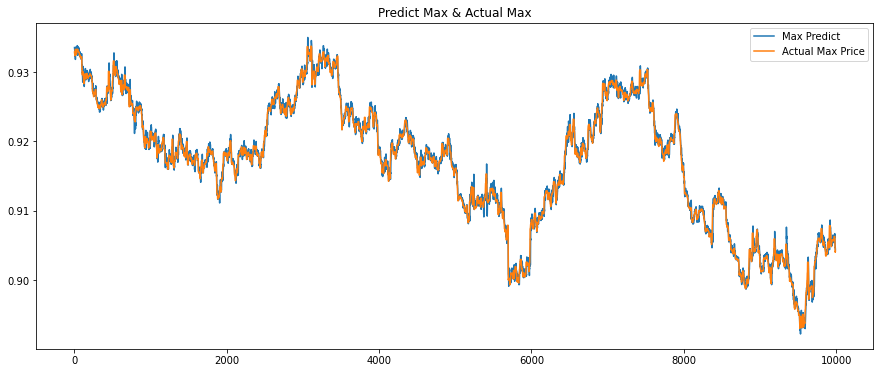

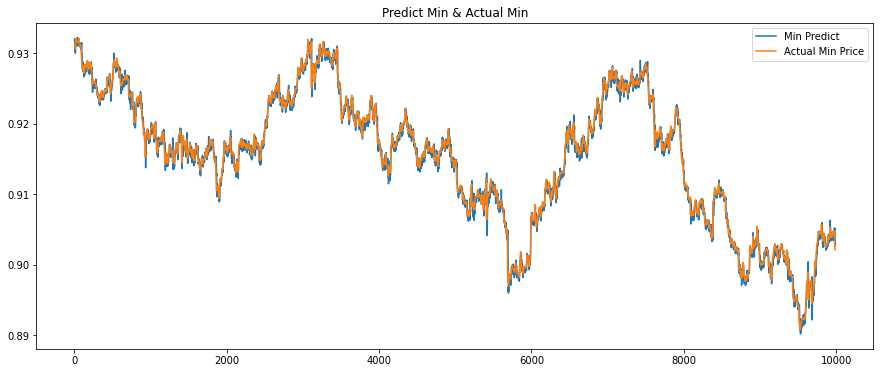

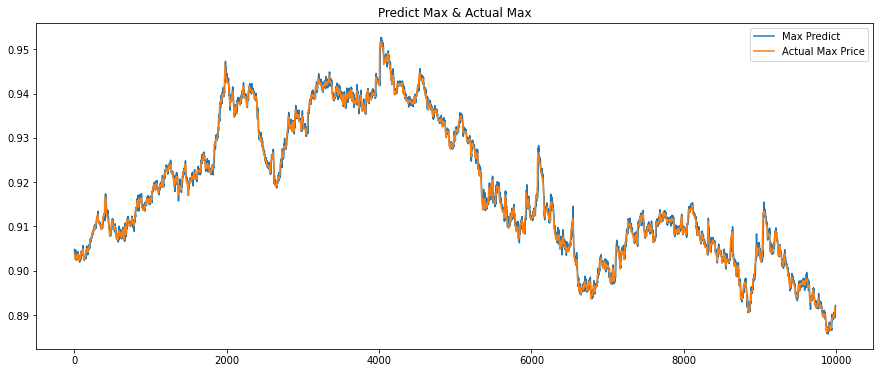

<Figure size 432x288 with 0 Axes>

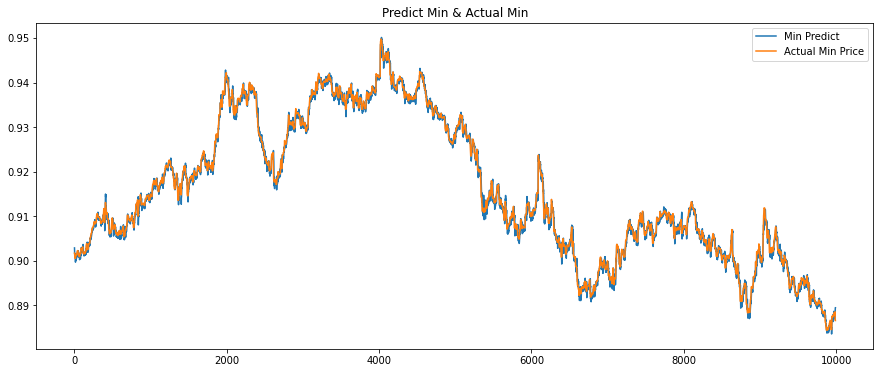

In [52]:
# visualize on valid set
visualize_result(RNN_model,valid_x_dict,valid_y_dict, val_price_scaler_min, val_price_scaler_max,valid_minprice,valid_maxprice)
# visualize on test set
print('=' * 80)
visualize_result(RNN_model,test_x_dict,test_y_dict, test_price_scaler_min, test_price_scaler_max,test_minprice,test_maxprice)


In [ ]:
# visualize on valid set
visualize_result(LSTM_model,valid_x_dict,valid_y_dict, val_price_scaler_min, val_price_scaler_max,valid_minprice,valid_maxprice)
# visualize on test set
print('=' * 80)
visualize_result(LSTM_model,test_x_dict,test_y_dict, test_price_scaler_min, test_price_scaler_max,test_minprice,test_maxprice)


313/313 [==============================] - 15s 35ms/step
----------------------------------------------------------------------------------------------------
MinMax Price Prediction Result: 
Model:
Mean Absolute Error: 0.01044610
Mean Absolute Percentage Error: 1.14071292
Mean Square Error: 0.00016924
Root Mean Square Error: 0.01300929

Model:
Mean Absolute Error: 0.01048284
Mean Absolute Percentage Error: 1.14690867
Mean Square Error: 0.00017053
Root Mean Square Error: 0.01305890

Accuracy for predicting buy hold sell label: 0.3750
              precision    recall  f1-score   support

           0       1.00      0.38      0.55      9991
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.38      9991
   macro avg       0.33      0.13      0.18      9991
weighted avg       1.00      0.38      0.55      9991

--------------------------------------------------------------------------------

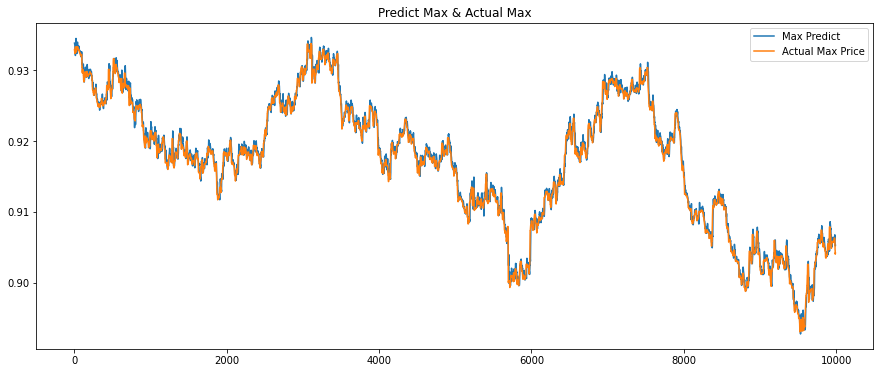

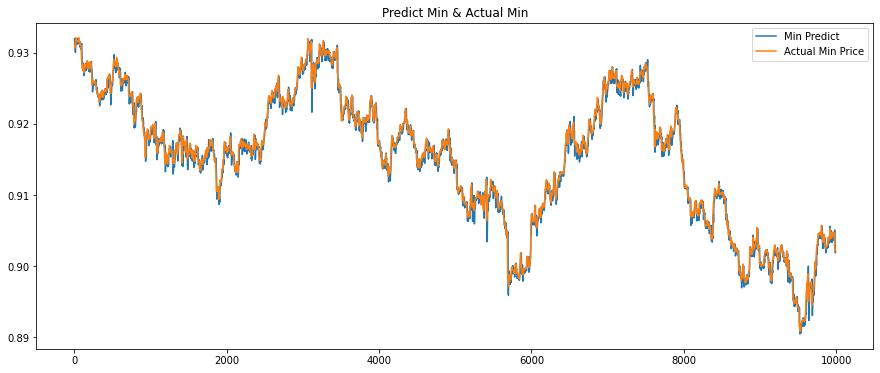

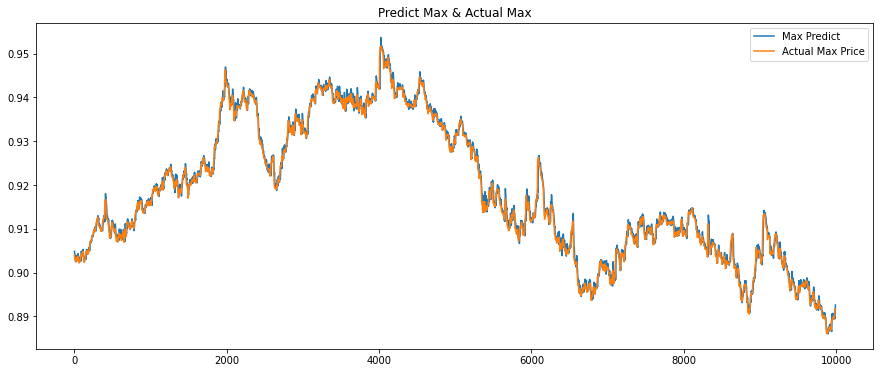

<Figure size 432x288 with 0 Axes>

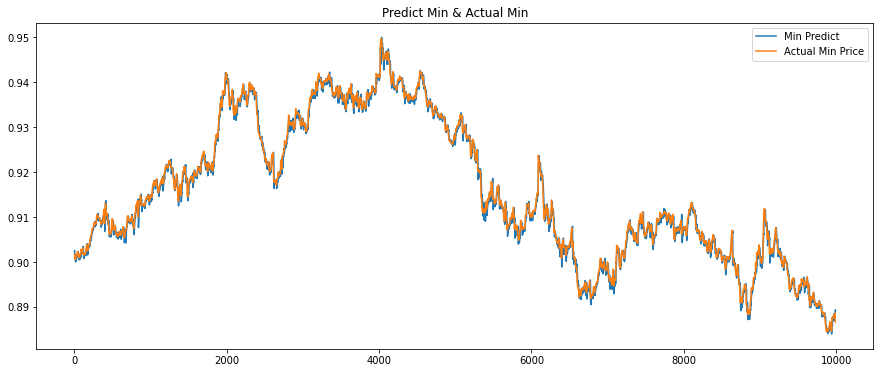

In [58]:
# visualize on valid set
visualize_result(Bi_LSTM_Model,valid_x_dict,valid_y_dict, val_price_scaler_min, val_price_scaler_max,valid_minprice,valid_maxprice)
# visualize on test set
print('=' * 80)
visualize_result(Bi_LSTM_Model,test_x_dict,test_y_dict, test_price_scaler_min, test_price_scaler_max,test_minprice,test_maxprice)

313/313 [==============================] - 59s 188ms/step
----------------------------------------------------------------------------------------------------
MinMax Price Prediction Result: 
Model:
Mean Absolute Error: 0.01044344
Mean Absolute Percentage Error: 1.14044053
Mean Square Error: 0.00016917
Root Mean Square Error: 0.01300659

Model:
Mean Absolute Error: 0.01048380
Mean Absolute Percentage Error: 1.14698096
Mean Square Error: 0.00017057
Root Mean Square Error: 0.01306019

Accuracy for predicting buy hold sell label: 0.3929
              precision    recall  f1-score   support

           0       0.71      0.41      0.52      6486
           1       0.41      0.37      0.39      3505
           2       0.00      0.00      0.00         0

    accuracy                           0.39      9991
   macro avg       0.37      0.26      0.30      9991
weighted avg       0.60      0.39      0.47      9991

-------------------------------------------------------------------------------

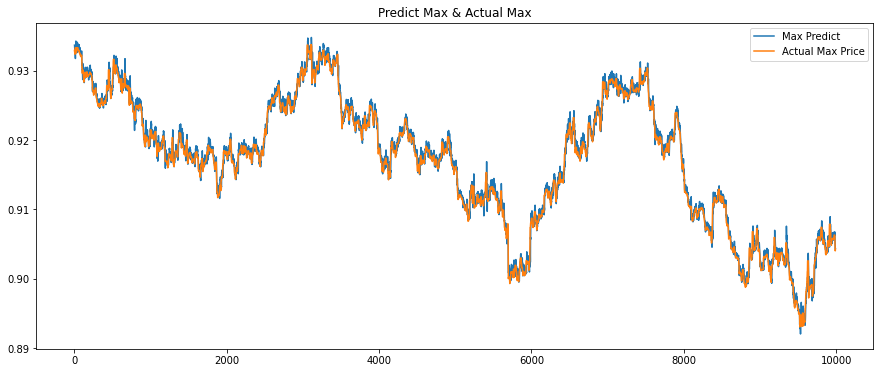

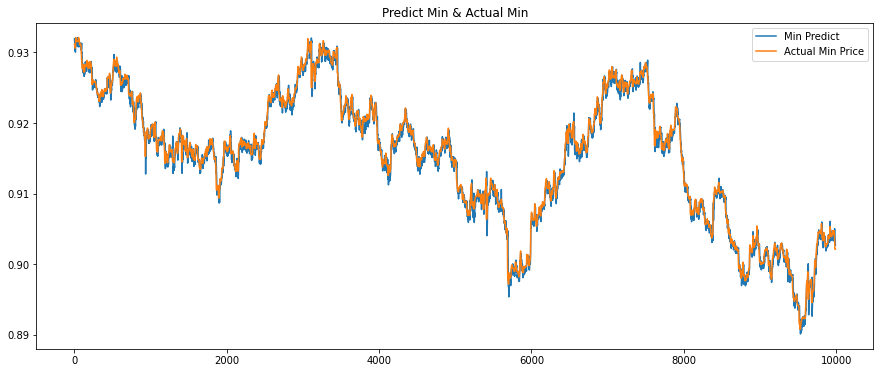

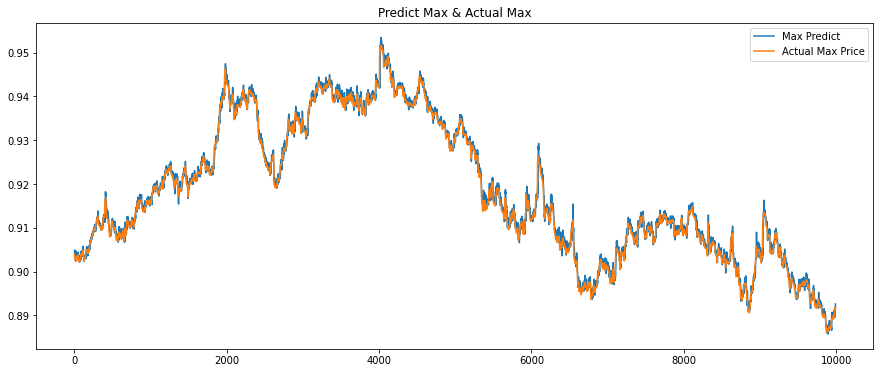

<Figure size 432x288 with 0 Axes>

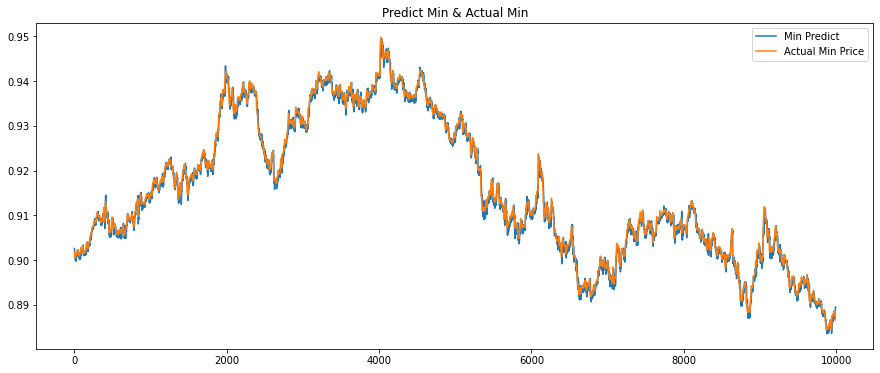

In [26]:
# visualize on valid set
visualize_result(Transformer,valid_x_dict,valid_y_dict, val_price_scaler_min, val_price_scaler_max,valid_minprice,valid_maxprice)
# visualize on test set
print('=' * 80)
visualize_result(Transformer,test_x_dict,test_y_dict, test_price_scaler_min, test_price_scaler_max,test_minprice,test_maxprice)

<Figure size 432x288 with 0 Axes>

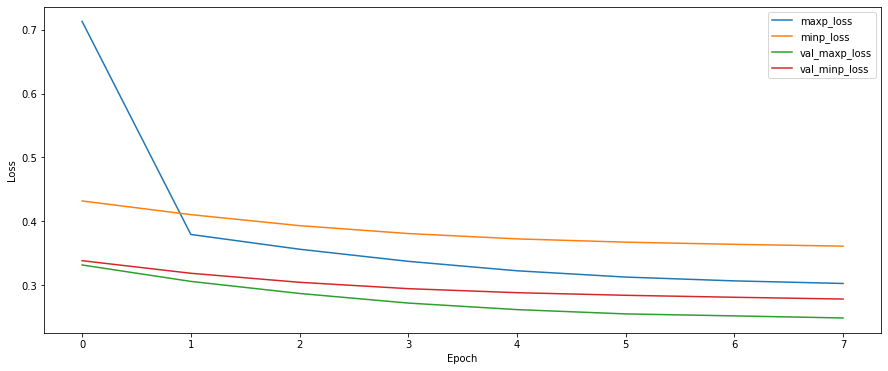

In [59]:
visualize_history(history)

# Save Model

In [28]:
# save model
Transformer.save('C:\\Users\\HFY\\Desktop\\capstone\\w13\\models\\Transformer_epo6.h5')
# load model
# Transformer = load_model('C:\\Users\\HFY\\Desktop\\capstone\\w13\\models\\Transformer_best.h5')

In [ ]:
# plot model
a= tf.keras.utils.plot_model(Transformer, to_file='.\model.png', show_shapes=True)